# ELMo for Aspect-Target Sentiment Classification

В этом ноутбуке мы исследуем применение модели ELMo для решения задачи Aspect-Target Sentiment Classification.

In [0]:
#!pip install allennlp
#!pip install transformers

In [2]:
import os
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm

from allennlp.modules.elmo import Elmo, batch_to_ids
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from transformers import AdamW

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Примонтируем наш гугл-диск, если мы решили его использовать.

In [3]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

### Данные для англоязычного датасета

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. В каждом отзыве есть т.н. аспектные термины, по которым мы должны указать тональность. В качестве примера можно привести отзыв из датасета:
```xml
<sentence id="1634">
    <text>The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.</text>
    <aspectTerms>
        <aspectTerm term="food" polarity="positive" from="4" to="8"/>
        <aspectTerm term="kitchen" polarity="positive" from="55" to="62"/>
        <aspectTerm term="menu" polarity="neutral" from="141" to="145"/>
    </aspectTerms>
    <aspectCategories>
        <aspectCategory category="food" polarity="positive"/>
    </aspectCategories>
</sentence>
```
Здесь аспектные термины -- это слова food, kitchen, menu. Аттрибуты from, to указывают на позицию термина в предложении.



Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
def xml2pandas(data_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'sentence_id': [], 'text': [], 'term': [],
                 'from': [], 'to': [], 'sentiment': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for sentence in soup.find_all('sentence'):
            # Если нет аспектных терминов
            if sentence.find('aspectTerms') is None:
                continue
            terms = sentence.find('aspectTerms').find_all(
                'aspectTerm'
            )
            for term in terms:
                data_dict['term'].append(term['term'])
                data_dict['from'].append(term['from'])
                data_dict['to'].append(term['to'])
                data_dict['sentiment'].append(term['polarity'])

                data_dict['sentence_id'].append(sentence['id'])
                data_dict['text'].append(sentence.find('text').text)

    data = pd.DataFrame(data_dict)
    data['from'] = data['from'].astype(int)
    data['to'] = data['to'].astype(int)
    return data

In [0]:
data_train_raw_path = os.path.join(
    DATA_PREFIX, 'raw', "SemEval'14-ABSA-TrainData_v2 & AnnotationGuidelines", 
    'Restaurants_Train_v2.xml'
)

data_test_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'ABSA_Gold_TestData', 'Restaurants_Test_Gold.xml'
)

data_train = xml2pandas(data_train_raw_path)
data_test = xml2pandas(data_test_raw_path)

In [9]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,But the staff was so horrible to us.,staff,8,13,negative
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral


In [10]:
data_test.head()

,sentence_id,text,term,from,to,sentiment
0,32897564#894393#2,The bread is top notch as well.,bread,4,9,positive
1,33070600#670328#0,I have to say they have one of the fastest del...,delivery times,43,57,positive
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,Food,0,4,positive
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,coffee,23,29,positive
4,32894246#870052#0,"Certainly not the best sushi in New York, howe...",sushi,23,28,conflict


Теперь, чтобы нормально это обучать надо как-то сохранить информацию о местопложении аспектных терминов (иначе токенизация порушит наши индексы, и они перестанут работать). В общем случае, нам надо хранить слайс индексов, которые будут отвечать за аспектный термин после токенизации.

Чтобы выполнить токенизацию и понять, где все еще находится аспектный термин, нам потребуется поставить какие-то маркеры. Попробуем проверить, что в наших текстах нет символов <, >, которыми мы обозначим границы аспектных терминов.

In [11]:
print(data_train['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())
print(data_test['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())

0
0
0
0


Обрамим аспектные термины символами <<, >>, чтобы потом после токенизации сразу понять, где они.

In [12]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,But the staff was so horrible to us.,staff,8,13,negative
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral


In [13]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
nlp = spacy.load("en_core_web_sm")

In [0]:
def tokenize(df_orig, nlp):
    df = df_orig.copy()
    from_tokens = []
    to_tokens = []
    tokenized_texts = []
    for i, row in df.iterrows():
        raw_text = row['text']
        from_index = row['from']
        to_index = row['to']
        text = (raw_text[:from_index] + '< ' + raw_text[from_index:to_index] 
                + ' >' + raw_text[to_index:])
        doc = nlp(text)
        tokens = [x.text for x in doc]
        tokenized_texts.append([x for x in tokens if x not in ['<', '>']])
        try:
            from_tokens.append(tokens.index('<') + 1)
            to_tokens.append(tokens.index('>'))
        except ValueError as e:
            print(raw_text)
            print(tokens)
    df['from'] = from_tokens
    df['to'] = to_tokens
    df['text'] = tokenized_texts
    return df

In [16]:
data_train = tokenize(data_train, nlp)
data_test = tokenize(data_test, nlp)
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,"[But, the, staff, was, so, horrible, to, us, .]",staff,3,4,negative
1,2777,"[To, be, completely, fair, ,, the, only, redee...",food,12,13,positive
2,1634,"[The, food, is, uniformly, exceptional, ,, wit...",food,2,3,positive
3,1634,"[The, food, is, uniformly, exceptional, ,, wit...",kitchen,11,12,positive
4,1634,"[The, food, is, uniformly, exceptional, ,, wit...",menu,28,29,neutral


Проверим, что ничего не сломалось.

In [17]:
print(data_train['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_train['text'].apply(lambda x: '>' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '>' in ''.join(x)).sum())

0
0
0
0


Теперь можем разделить данные на валидацию и трейн.

In [0]:
data_train, data_valid = train_test_split(
    data_train, test_size=0.2, random_state=random_state
)

Будем использовать AllenNLP. В качестве примера будем использовать [официальный сайт](http://docs.allennlp.org/master/tutorials/how_to/elmo/#using-elmo-as-a-pytorch-module-to-train-a-new-model). Можно заметить, что там уже идет обработка батча, поэтому никаким образом паддинги нам обрабатывать не надо, а потому torchtext не нужен.

In [0]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'neutral': 2, 'conflict': 3}

In [0]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, sentiment_vocab):
        self.data = data
        self.sentiment_vocab = sentiment_vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        text = self.data['text'].iloc[index]
        from_index = torch.tensor([self.data['from'].iloc[index]], 
                                  dtype=torch.long)
        to_index = torch.tensor([self.data['to'].iloc[index]], dtype=torch.long)
        sentiment = torch.tensor(
            [self.sentiment_vocab[self.data['sentiment'].iloc[index]]], 
            dtype=torch.long
        )
        return (text, from_index, to_index, sentiment)

    def __len__(self):
        return len(self.data)

In [0]:
def collate_fn(batch):
    """Специальная функция для обработки паддингов."""
    # распакуем батч
    text, from_index, to_index, sentiment = zip(*batch)
    # состакаем все кроме текстов (с ними потом разберется сам ELMo)
    from_index = torch.stack(from_index)
    to_index = torch.stack(to_index)
    sentiment = torch.stack(sentiment)
    return text, from_index, to_index, sentiment

Проверим, что батчи работают правильно.

In [22]:
train_dataset = Dataset(data_train, sentiment_vocab)
dataloader_train = DataLoader(train_dataset, batch_size=5, 
                              shuffle=True, num_workers=4, 
                              collate_fn=collate_fn)

for i_batch, (text_batched, from_batched, to_batched, 
              sentiment_batched) in enumerate(dataloader_train):
    if i_batch == 1:
        break
    print(from_batched)
    print(from_batched.size())

tensor([[ 6],
        [ 7],
        [ 2],
        [13],
        [14]])
torch.Size([5, 1])


### Модель

Зададим архитектуру нашей сети. Надо сразу пояснить некоторые детали. Нашему аспектному термину будет соответствовать несколько токенов, но каждому токену соответствует свой эмбеддинг. Поэтому нам надо как-то саггрегировать эмбеддинги для одного аспектного термина. Я пока предлагаю просто их усреднить.

С точки зрения технической реализации мы будем использовать битову маску, получаемую из индексов from, to.

In [0]:
class SimpleELMOClassifier(nn.Module):

    def __init__(self, num_sentiments, elmo, embeddings_dim, device):
        super(SimpleELMOClassifier, self).__init__()

        self.device = device

        self.elmo = elmo
        self.elmo_layer_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_layer_coef_2 = nn.Parameter(torch.ones(1))

        self.to_sentiments = nn.Linear(embeddings_dim, num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, texts, from_indices, to_indices, hidden=None):
        # get elmo embeddings
        character_ids = batch_to_ids(texts).to(device=self.device)
        embeddings_raw = self.elmo(character_ids)['elmo_representations']
        embeddings = (
            embeddings_raw[0] * self.elmo_layer_coef_1 
            + embeddings_raw[1] * self.elmo_layer_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=self.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # get average of embedings according to bit_matrix
        embeddings_terms = (torch.sum(embeddings*torch.unsqueeze(bit_matrix, -1), 
                                      dim=1) 
                            / torch.unsqueeze(torch.sum(bit_matrix, dim=1), -1))


        sentiments = self.to_sentiments(embeddings_terms)
        return sentiments

Инициализируем нашу сеть.

In [37]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab)

options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 2, dropout=0)

model = SimpleELMOClassifier(
    num_sentiments, elmo, 1024, device
)
model

SimpleELMOClassifier(
  (elmo): Elmo(
    (_elmo_lstm): _ElmoBiLm(
      (_token_embedder): _ElmoCharacterEncoder(
        (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
        (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
        (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
        (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
        (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
        (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
        (_highways): Highway(
          (_layers): ModuleList(
            (0): Linear(in_features=2048, out_features=4096, bias=True)
            (1): Linear(in_features=2048, out_features=4096, bias=True)
          )
        )
        (_projection): Linear(in_features=2048, out_features=512, bias=True)
      )
      (_elmo_lstm): ElmoLstm(
        (forward_layer_0): LstmCellWithProjection(
  

### Тренировочный цикл

Здесь мы реализуем тренировочный цикл для нашей модели.

In [0]:
def train_loop(train_iter, val_iter, model, opt, scheduler, criterion, epochs, 
               early_stopping):
    train_losses = []
    val_losses = []
    train_acc_values = []
    val_acc_values = []
    best_val_loss = 100
    best_val_acc = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_acc = 0
        model.train() 
        for batch in tqdm(train_iter, leave=False): 

            texts, from_indices, to_indices, sentiments = batch
            from_indices = from_indices.to(device=device)
            to_indices = to_indices.to(device=device)
            sentiments = sentiments.to(device=device).squeeze(1)

            opt.zero_grad()
            preds = model(texts, from_indices, to_indices)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_acc += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_iter.dataset)
        train_losses.append(train_loss)
        train_acc /= len(train_iter.dataset)
        train_acc_values.append(train_acc)

        val_loss = 0.0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts, from_indices, to_indices, sentiments = batch
                from_indices = from_indices.to(device=device)
                to_indices = to_indices.to(device=device)
                sentiments = sentiments.to(device=device).squeeze(1)

                opt.zero_grad()
                preds = model(texts, from_indices, to_indices)

                preds = model(texts, from_indices, to_indices)  
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_acc += np.sum(
                    pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
                )

        val_loss /= len(valid_iter.dataset)
        val_acc /= len(valid_iter.dataset)
        val_losses.append(val_loss)
        val_acc_values.append(val_acc)

        if val_acc > best_val_acc:
            not_improves = 0
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_save)
            print('------SAVED------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss*: {1000*train_loss:.5f}, '
              f'Validation Loss*: {1000*val_loss:.5f}, \n'
              f'Training Acc: {train_acc:.5f}, '
              f'Validation Acc: {val_acc:.5f}')

    return train_losses, val_losses, train_acc_values, val_acc_values

In [0]:
remain_sentiments = ['neutral', 'positive', 'negative']

train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], sentiment_vocab
)
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)], sentiment_vocab
)

batch_size = 128

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

test_iter = DataLoader(test_dataset, batch_size=batch_size, 
                       shuffle=True, num_workers=4, 
                       collate_fn=collate_fn)

In [0]:
model = model.to(device=device)
learning_rate = 1e-3
early_stopping = 5
grad_clipping_value = 1
epochs = 30

opt = AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_simple.pt')

In [41]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, valid_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping
)


------SAVED------
Epoch: 1, Training Loss*: 8.46273, Validation Loss*: 7.17580, 
Training Acc: 0.57337, Validation Acc: 0.62672


------SAVED------
Epoch: 2, Training Loss*: 6.45426, Validation Loss*: 6.50644, 
Training Acc: 0.65473, Validation Acc: 0.67080


------SAVED------
Epoch: 3, Training Loss*: 5.72248, Validation Loss*: 6.23466, 
Training Acc: 0.69332, Validation Acc: 0.68182


------SAVED------
Epoch: 4, Training Loss*: 5.30229, Validation Loss*: 6.05790, 
Training Acc: 0.72462, Validation Acc: 0.69697


------SAVED------
Epoch: 5, Training Loss*: 4.97903, Validation Loss*: 6.09368, 
Training Acc: 0.74131, Validation Acc: 0.70248


Epoch: 6, Training Loss*: 4.73192, Validation Loss*: 6.07978, 
Training Acc: 0.76182, Validation Acc: 0.69835


------SAVED------
Epoch: 7, Training Loss*: 4.53567, Validation Loss*: 6.18178, 
Training Acc: 0.77121, Validation Acc: 0.70799


------SAVED------
Epoch: 8, Training Loss*: 4.32071, Validation Loss*: 6.14357, 
Training Acc: 0.78686, Validation Acc: 0.71625


Epoch: 9, Training Loss*: 4.13442, Validation Loss*: 6.12748, 
Training Acc: 0.79138, Validation Acc: 0.70523


Epoch: 10, Training Loss*: 3.98010, Validation Loss*: 6.26832, 
Training Acc: 0.80389, Validation Acc: 0.71074


Epoch: 11, Training Loss*: 3.87576, Validation Loss*: 6.67255, 
Training Acc: 0.81328, Validation Acc: 0.69835


Epoch: 12, Training Loss*: 3.78938, Validation Loss*: 6.55317, 
Training Acc: 0.81745, Validation Acc: 0.71074


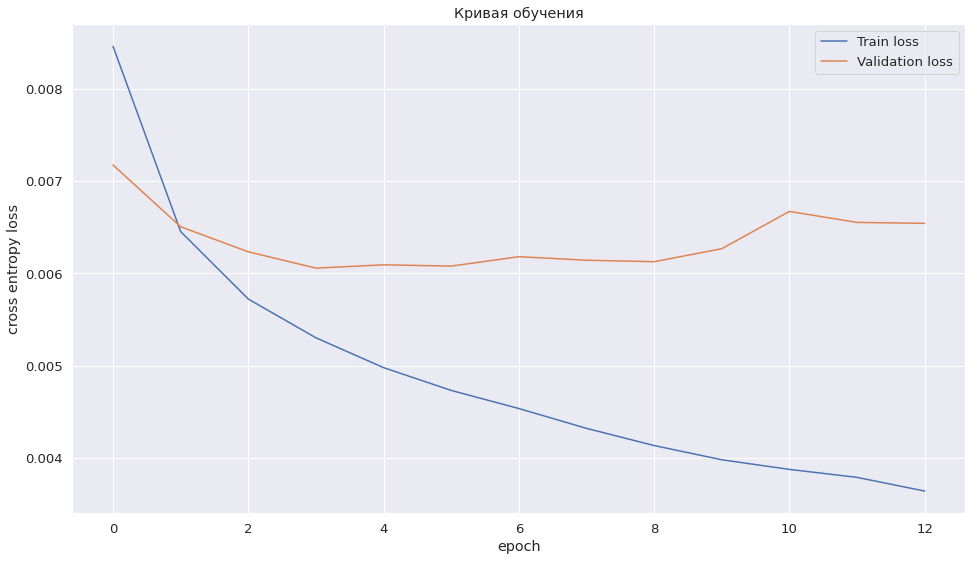

In [42]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

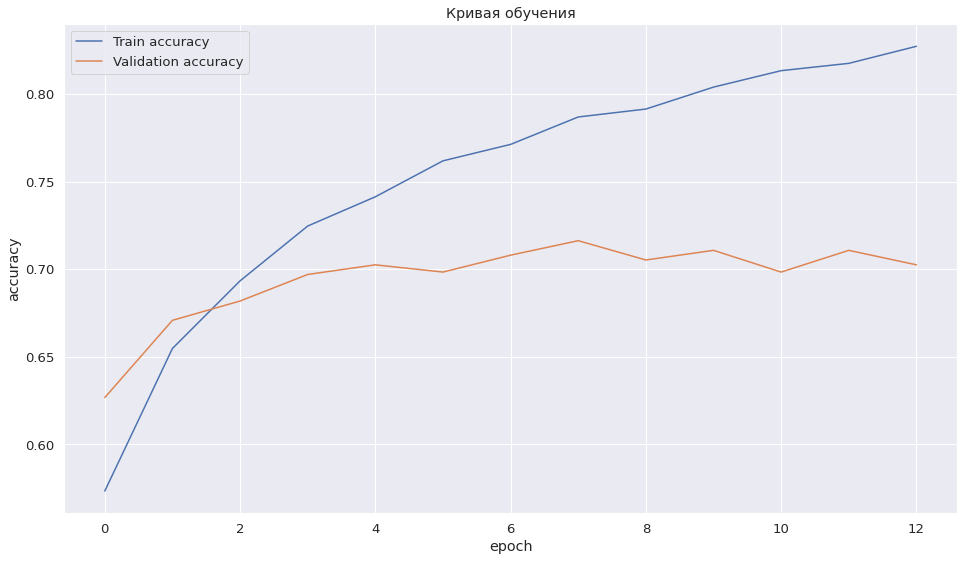

In [43]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [44]:
model.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts, from_indices, to_indices, sentiments = batch
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(texts, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [47]:
accuracy = accuracy_score(all_preds, all_answers)

print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.73750


### Что стоит еще сделать

1. Проверить, что решаемая такой моделью задача совпадает с решаемой задачей на русском языке.
2. Поэкспериментировать с моделью: 
    * dropout (что-то пробовали), 
    * другие эмбеддинги (взятие самого большого glove улучшило ситуацию), 
    * bidirectional (в текущей архитектуре это, кажется, не очень поможет потому что берется только выходное состояние), 
    * l2-регуляризация, как в статье (добавили)
    * доучивание эмбеддингов вместо заморозки
    * увеличение числа слоев lstm (кажется, что прироста не дало)
3. Проверить, что в текущей модели от использования эмбеддингов для аспектов вообще есть толк (можно попробовать их отключить как-то).